In [1]:
import jax
import jax.numpy as jnp
from jax import jacfwd, jacrev
import matplotlib.pyplot as plt
import jax.scipy.linalg as jlinalg

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

from parsmooth import MVNStandard
from parsmooth import FunctionalModel
from parsmooth.sequential._filtering import filtering
from parsmooth.linearization import extended, extended_hessian
from parsmooth.sequential._filtering_Newton import filtering as newton_filtering
from notebooks.bearing_data_pe import inverse_bearings
from bearing_data import get_data, make_parameters

In [2]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

T = 100
_, true_states, ys = get_data(x0, dt, r, T, s1, s2)
Q, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

chol_Q = jnp.linalg.cholesky(Q)
chol_R = jnp.linalg.cholesky(R)

m0 = jnp.array([-4., -1., 2., 7., 3.])
chol_P0 = jnp.eye(5)
P0 = jnp.eye(5)

init = MVNStandard(m0, P0)

# positions = inverse_bearings(ys, s1, s2)
# states = jnp.concatenate([jnp.concatenate([jnp.zeros((1,2)), positions], axis = 0),
#                           jnp.zeros((T+1,3))], axis = 1)
#
# initial_states =  MVNStandard(states,jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))


initial_states =  MVNStandard(jnp.repeat(jnp.array([[0., 0., 2., 7., 3.]]),T + 1, axis=0),
                                                     jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))

transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))
observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

 ### Filtering (Gauss-Newton)

In [4]:
#Filtering
filtered_states = filtering(ys, init, transition_model, observation_model, extended, initial_states)

### Batch solution

In [5]:
def mvn_loglikelihood(x, chol_cov):
    """multivariate normal"""
    dim = chol_cov.shape[0]
    y = jlinalg.solve_triangular(chol_cov, x, lower=True)
    normalizing_constant = (
            jnp.sum(jnp.log(jnp.abs(jnp.diag(chol_cov)))) + dim * jnp.log(2 * jnp.pi) / 2.0
    )
    norm_y = jnp.sum(y * y, -1)
    return -0.5 * norm_y - normalizing_constant

In [6]:
def LL(predict_trajectory, update_trajectory, z, measurement_fun, dynamic_fun, chol_Q, chol_R):
    mp_nominal = predict_trajectory
    mu_nominal = update_trajectory
    cost = mvn_loglikelihood(mu_nominal - dynamic_fun(mp_nominal), chol_Q) + mvn_loglikelihood(z - measurement_fun(mu_nominal), chol_R)
    return -cost

def lost_function(x):
    x0 = x[0]
    predict_traj =x[:-1]
    update_traj = x[1:]
    vmapped_fun = jax.vmap(LL, in_axes=[0, 0, 0, None, None, None, None])
    return jnp.sum(vmapped_fun(predict_traj, update_traj, ys, observation_function, transition_function, jnp.linalg.cholesky(Q), jnp.linalg.cholesky(R))) - mvn_loglikelihood(x0 - m0, jnp.linalg.cholesky(P0))


In [7]:
grad = jax.grad(lost_function, argnums=0)(initial_states.mean)
Hess = jacfwd(jacrev(lost_function))(initial_states.mean)

x_batch = initial_states.mean - jax.numpy.linalg.tensorsolve(Hess, grad)

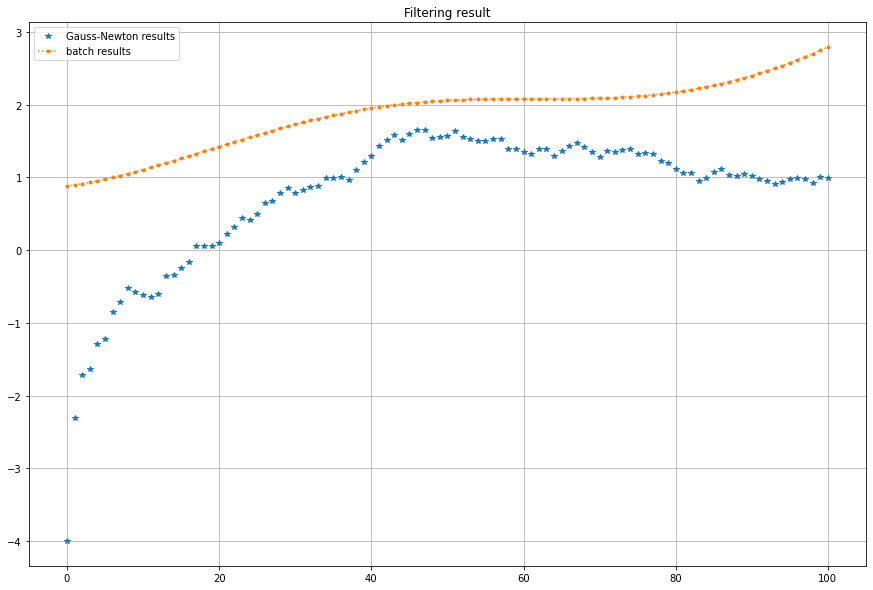

In [8]:
plt.figure(figsize=(15,10))
# plt.plot(filtered_states_newton.mean, "--", label="Newton results" )
plt.plot(filtered_states.mean[:,0], "*", label = "Gauss-Newton results")
plt.plot(x_batch[:,0], ".:", label = "batch results")
plt.title("Filtering result")
plt.grid()
plt.legend();

### Filtering (Newton)

In [9]:
filtered_states_newton = newton_filtering(ys, init, transition_model, observation_model, extended_hessian, initial_states)


In [10]:
filtered_states_newton.mean

DeviceArray([[-4., -1.,  2.,  7.,  3.],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
             [nan, nan, nan, nan, nan],
